## Installs and Imports

In [15]:
%%capture
!pip install tqdm pyLDAvis gensim numpy bokeh contractions datapane
!conda install -c conda-forge huggingface_hub -y

/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/sejaldua/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import datapane as dp
dp.login(token="c7bb2ee23e3719466176cd5edaac72357c7dc11c")

Connected successfully to https://datapane.com as sejaldua


'sejaldua'

## Data Acquisition via Gmail API

In [ ]:
from quickstart import get_service, get_data
service = get_service()
messages = get_data(service, 'Medium Daily Digest')

In [ ]:
print(len(messages))

In [ ]:
print(messages[0])

In [ ]:
# experimenting with a single message
message = messages[0]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
print(msg.keys())

In [ ]:
print(msg['snippet'])

In [ ]:
print(msg['payload']['parts'][0]['body']['data'][:200])

In [ ]:
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
print(msg_body[:1500])

In [ ]:
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)[:5]

### Regex Parsing of HTML Text

In [ ]:
def parse_email_digest(date, msg_body):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
    articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)]
    
    # workaround for old email Medium Daily Digest format prior to March 23, 2021
    if len(articles) == 0:
        articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n(.*) \r\n\ in (.*)\r\n(.*) min read', text, re.MULTILINE)]
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body and decode it from UTF-8
    content = msg['payload']['parts'][0]['body']['data']
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    
    # Extract article information for all articles featured in daily digest
    fetched_articles = parse_email_digest(date, msg_body)
    num_articles_fetched.append(len(fetched_articles))
    for articles in fetched_articles:
        data.append([date, *articles])


In [ ]:
for entry in data[:3]:
    print(entry)

In [ ]:
# TROUBLESHOOT HERE
# identify all zero articles fetched digest emails
message = messages[num_articles_fetched.index(0)]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
for date_dict in msg['payload']['headers']:
    if date_dict['name'] == 'Date':
        date = date_dict['value']
date = pd.to_datetime(date)
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
# print(text)

In [ ]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Author', 'Publication', 'Minutes'])
df['Minutes'] = df['Minutes'].astype(int)
df.to_csv('raw_data/article_data_via_gmail_api.csv', index=False)
df

## Load Data from CSV

In [142]:
df = pd.read_csv('https://raw.githubusercontent.com/sejaldua/digesting-the-digest/main/raw_data/article_data_via_gmail_api.csv')
df[['Title', 'Subtitle']] = df[['Title', 'Subtitle']].astype('string')
df = df.drop_duplicates(subset=['Title', 'Subtitle'], keep='first', ignore_index=True)
df

Date  \
0     2021-08-30 11:40:00+00:00   
1     2021-08-30 11:40:00+00:00   
2     2021-08-30 11:40:00+00:00   
3     2021-08-30 11:40:00+00:00   
4     2021-08-30 11:40:00+00:00   
...                         ...   
7062  2020-01-01 16:30:00+00:00   
7063  2020-01-01 16:30:00+00:00   
7064  2020-01-01 16:30:00+00:00   
7065  2020-01-01 16:30:00+00:00   
7066  2020-01-01 16:30:00+00:00   

                                                                              Title  \
0     Towards Better Data Visualizations and Graphics                                 
1     Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…   
2     Data Science Learning Path with Python                                          
3     Jupyter Notebook can do that?                                                   
4     Reshaping Mitochondria to Reverse Obesity                                       
...                                         ...                                       
7062  How to Get the Unquantifiable Benefits of Cold Showers                          
7063  Screw Productivity Hacks: My Morning Routine Is Getting up Late                 
7064  The Latest Science on Chronic Pain Is Fascinating                               
7065  5 scientific myths you probably believe about the Universe                      
7066  How Jo March Became a Girlboss                                                  

                                                                                                           Subtitle  \
0     Design principles for creating data-based graphics and visuals                                                  
1     Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…   
2     I often receive messages from new members of Jakarta AI Research Discord Server, "where do I start to learn…    
3     Soup up your cells with a couple of key extensions                                                              
4     Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice)     
...                                                                                                           ...     
7062  The surprising side effects that science can't measure and money can't buy                                      
7063  Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…      
7064  Experts can even predict who's likely to suffer or recover, based on brain structure and personality            
7065  How a little knowledge can bring about some huge misconceptions… and how to fix it.                             
7066  Every generation gets the 'Little Women' it deserves, and Greta Gerwig's film tells the story of a hungry…      

                      Author                Publication  Minutes  
0     Prashant Mudgal         Towards Data Science       5        
1     Vijay Vankayalapati     Geek Culture               6        
2     Andreas Chandra         Data Folks Indonesia       3        
3     Jesse Markowitz         CodeX                      5        
4     Gunnar De Winter        In Fitness And In Health   4        
...                ...                              ... ..        
7062  May Pang                Better Humans              10       
7063  Jessica Valenti         GEN                        3        
7064  Robert Roy Britt        Elemental                  14       
7065  Ethan Siegel            Starts With A Bang!        8        
7066  Madeline Leung Coleman  GEN                        9        

[7067 rows x 6 columns]

In [143]:
table = dp.DataTable(df)
report = dp.Report(table)
report.upload(name='initial_dataframe')

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/sejaldua/reports/wAw2Nak/initial-dataframe/) to view and share your report

## Quick Exploratory Visualizations

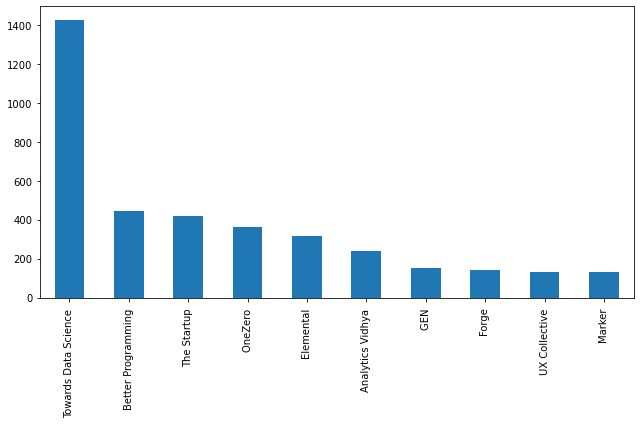

In [144]:
fig = plt.figure(figsize=(9,6))
df['Publication'].value_counts().iloc[:10].plot.bar();
plt.tight_layout();
fig.savefig('./figures/publication_counts.png')

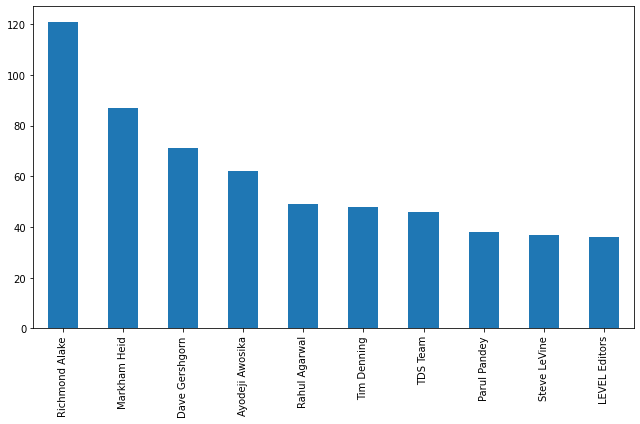

In [145]:
fig = plt.figure(figsize=(9,6))
df['Author'].value_counts().iloc[:10].plot.bar();
plt.tight_layout();
fig.savefig('./figures/author_counts.png')

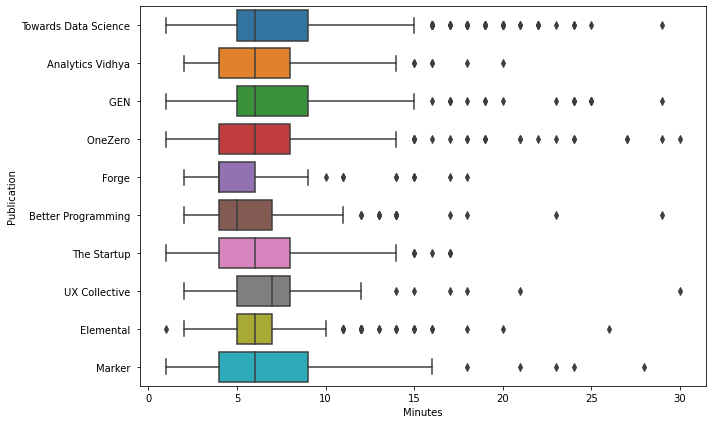

In [146]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.boxplot(data=df[(df['Minutes'] <= 30) & (df['Publication'].isin(df['Publication'].value_counts().iloc[:10].index))], x='Minutes', y='Publication')
plt.tight_layout()
fig.savefig('./figures/minutes_publication_boxplot.png')

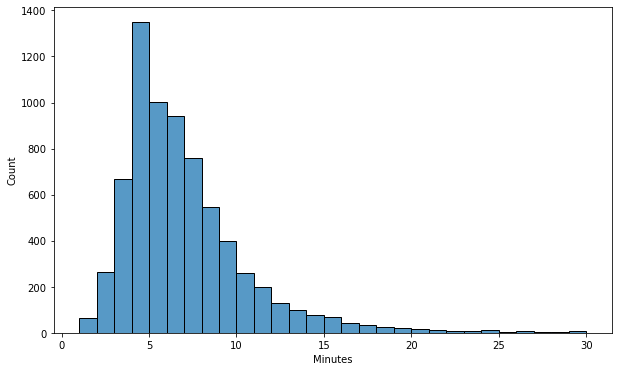

In [147]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.histplot(data=df[(df['Minutes'] <= 30)], x='Minutes', binwidth=1)
fig.savefig('./figures/minutes_distribution.png')

## Cleaning & Preprocessing

In [148]:
# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# NLP stuff
import contractions
import demoji
import string
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('wordnet')
import spacy

# Plotting tools
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from sklearn.manifold import TSNE
from pprint import pprint

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [149]:
df['text'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df

Date  \
0     2021-08-30 11:40:00+00:00   
1     2021-08-30 11:40:00+00:00   
2     2021-08-30 11:40:00+00:00   
3     2021-08-30 11:40:00+00:00   
4     2021-08-30 11:40:00+00:00   
...                         ...   
7062  2020-01-01 16:30:00+00:00   
7063  2020-01-01 16:30:00+00:00   
7064  2020-01-01 16:30:00+00:00   
7065  2020-01-01 16:30:00+00:00   
7066  2020-01-01 16:30:00+00:00   

                                                                              Title  \
0     Towards Better Data Visualizations and Graphics                                 
1     Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…   
2     Data Science Learning Path with Python                                          
3     Jupyter Notebook can do that?                                                   
4     Reshaping Mitochondria to Reverse Obesity                                       
...                                         ...                                       
7062  How to Get the Unquantifiable Benefits of Cold Showers                          
7063  Screw Productivity Hacks: My Morning Routine Is Getting up Late                 
7064  The Latest Science on Chronic Pain Is Fascinating                               
7065  5 scientific myths you probably believe about the Universe                      
7066  How Jo March Became a Girlboss                                                  

                                                                                                           Subtitle  \
0     Design principles for creating data-based graphics and visuals                                                  
1     Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…   
2     I often receive messages from new members of Jakarta AI Research Discord Server, "where do I start to learn…    
3     Soup up your cells with a couple of key extensions                                                              
4     Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice)     
...                                                                                                           ...     
7062  The surprising side effects that science can't measure and money can't buy                                      
7063  Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…      
7064  Experts can even predict who's likely to suffer or recover, based on brain structure and personality            
7065  How a little knowledge can bring about some huge misconceptions… and how to fix it.                             
7066  Every generation gets the 'Little Women' it deserves, and Greta Gerwig's film tells the story of a hungry…      

                      Author                Publication  Minutes  \
0     Prashant Mudgal         Towards Data Science       5         
1     Vijay Vankayalapati     Geek Culture               6         
2     Andreas Chandra         Data Folks Indonesia       3         
3     Jesse Markowitz         CodeX                      5         
4     Gunnar De Winter        In Fitness And In Health   4         
...                ...                              ... ..         
7062  May Pang                Better Humans              10        
7063  Jessica Valenti         GEN                        3         
7064  Robert Roy Britt        Elemental                  14        
7065  Ethan Siegel            Starts With A Bang!        8         
7066  Madeline Leung Coleman  GEN                        9         

                                                                                                                                                                                             text  
0     Towards Better Data Visualizations and Graphics Design principles for creating data-based graphics and visuals   

In [150]:
def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split()]))
    
    # remove emojis
    text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in nltk.corpus.stopwords.words('english') if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

df['text'] = preprocess(df['text'])
df.rename(columns={'Date': 'date'}, inplace=True)
df[['date', 'text']].to_csv('medium-suggested-cleaned.csv', index=False)
print(*df['text'].head(20).values, sep='\n')

towards better data visualization graphic design principle creating databased graphic visuals
making sense million row instacart data exploratory data analysis instacart one hottest silicon valley startup last decade valued whopping
data science learning path python often receive message new member jakarta research discord server start learn
jupyter notebook soup cell couple key extension
reshaping mitochondrion reverse obesity changing shape mitochondrion reverse molecular process underlying obesity mouse
data type data science quick guide difference quantitative qualitative data
reducing product stockouts hypermarket time series modeling pragmatic guide creating data science product limited data high business constraint
summarize article using nlp summarize text using simple technique
tim ferriss system mastering skill pure genius method world successful human guinea pig
datasets need practice data science skill make great great collection different kind datasets
python package moder

## Wordcloud

In [151]:
all_words = ' '.join(df['text'].values).split()
all_words[:20]

['towards',
 'better',
 'data',
 'visualization',
 'graphic',
 'design',
 'principle',
 'creating',
 'databased',
 'graphic',
 'visuals',
 'making',
 'sense',
 'million',
 'row',
 'instacart',
 'data',
 'exploratory',
 'data',
 'analysis']

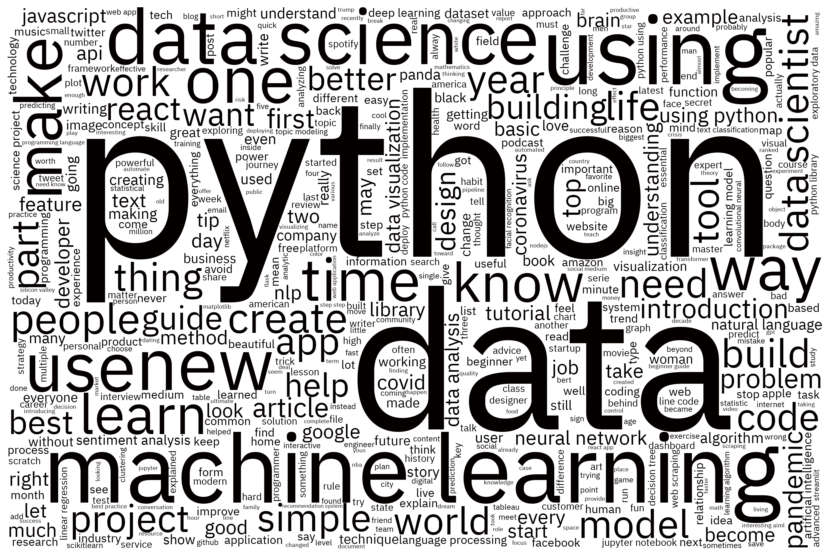

In [152]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Regular.ttf', 
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500, stopwords=STOPWORDS).generate_from_text(' '.join(df['text'].values))

# set the word color to black
wordcloud.recolor(color_func = black_color_func)
fig = plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
fig.savefig('./figures/wordcloud.png')

## Topic Modeling Prep

### Data Preprocessing

In [153]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text'].tolist()))
print(data_words[:1])
print("Total docs:", len(data_words))

[['towards', 'better', 'data', 'visualization', 'graphic', 'design', 'principle', 'creating', 'databased', 'graphic', 'visuals']]
Total docs: 7067


In [154]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [155]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [199]:
data_preprocessed = make_bigrams(data_words)

### Dictionary & Corpus

In [223]:
# Create dictionary and corpus needed for topic modeling

# dictionary is a mapping of word_id --> word, as the variable name implies
id2word = corpora.Dictionary(data_preprocessed)
id2word.filter_extremes(no_below=15, no_above=0.6, keep_n=50000)

# the preprocessed and lemmatized documents themselves
texts = data_preprocessed

# corpus is a mapping of word_id --> word frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1)]]


In [224]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('better', 1),
  ('creating', 1),
  ('data', 1),
  ('design', 1),
  ('graphic', 2),
  ('principle', 1),
  ('towards', 1),
  ('visualization', 1)]]

## Latent Dirichlet Allocation (LDA)

In [225]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [226]:
# Print the Keyword in the 10 topics
pprint(lda_model.show_topics(formatted=False)[:5])
doc_lda = lda_model[corpus]

[(0,
  [('get', 0.0683621),
   ('people', 0.064275734),
   ('black', 0.030032333),
   ('book', 0.028695362),
   ('writing', 0.026117584),
   ('twitter', 0.021953672),
   ('coding', 0.019962255),
   ('company', 0.01965732),
   ('sentiment_analysis', 0.018185304),
   ('many', 0.01791349)]),
 (1,
  [('want', 0.07491783),
   ('javascript', 0.040491145),
   ('step', 0.03952279),
   ('would', 0.034577034),
   ('little', 0.026792547),
   ('apple', 0.025234846),
   ('word', 0.021649752),
   ('conversation', 0.020602481),
   ('application', 0.019886851),
   ('based', 0.019676704)]),
 (2,
  [('data', 0.13246292),
   ('science', 0.062244248),
   ('code', 0.049421027),
   ('design', 0.036253273),
   ('scientist', 0.031019527),
   ('better', 0.030919697),
   ('right', 0.025352282),
   ('simple', 0.02318741),
   ('programming', 0.022245664),
   ('visualization', 0.021161966)]),
 (3,
  [('developer', 0.045152657),
   ('help', 0.043604266),
   ('habit', 0.040928744),
   ('brain', 0.036037996),
   ('ma

### Model Evaluation Metrics

In [227]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_preprocessed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -6.92
Coherence Score:  0.4


### pyLDAvis: Topic Distance Visualization and Relevant Terms

In [228]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(lda_model.num_topics))
viz_prep = True
if viz_prep:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(lda_model.num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.449100 -0.008467  1       1        22.098979
2     -0.061797 -0.443207  2       1        12.189977
5     -0.082425  0.075913  3       1        10.226924
6     -0.054052  0.062023  4       1        9.828419 
7     -0.061760  0.062318  5       1        9.595903 
9     -0.054636  0.071152  6       1        9.266949 
0     -0.043410  0.051534  7       1        7.661269 
3     -0.042106  0.048428  8       1        7.431853 
8     -0.024856  0.040674  9       1        6.131801 
1     -0.024058  0.039632  10      1        5.567926 , topic_info=             Term         Freq        Total Category  logprob  loglift
2     data         945.000000   945.000000   Default  30.0000  30.0000
73    not          1152.000000  1152.000000  Default  29.0000  29.0000
24    python       833.000000   833.000000   Default  28.0000  28.0000
19    learning     499.000000   499.000000   Default  27.0000  27.0000
65    make         428.000000   428.000000   Default  26.0000  26.0000
...    ...                ...          ...       ...      ...      ...
284   tale         37.029954    37.969073    Topic10 -4.4765   2.8631 
1086  explanation  35.863671    36.774359    Topic10 -4.5085   2.8631 
643   away         35.385764    36.296519    Topic10 -4.5219   2.8627 
1302  forget       34.917242    35.828024    Topic10 -4.5352   2.8624 
1082  weight       34.492918    35.403611    Topic10 -4.5474   2.8621 

[330 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
363   7      0.982523  actually 
838   6      0.990138  advice   
339   6      0.986936  algorithm
602   5      0.988595  also     
1140  9      0.993746  amazon   
...  ..           ...   ...     
89    7      0.992179  writing  
117   5      0.995712  year     
125   8      0.983947  yes      
453   6      0.978727  yet      
891   8      0.977922  youtube  

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 7, 8, 10, 1, 4, 9, 2])

### Finding the most dominant topic in each sentence

In [229]:
def get_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts):
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document and the probability associated with it
    for i, row in enumerate(ldamodel[corpus]):
        try:
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
        except:
            row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        dom_topic = row[0]
        topic_num, topic_rep = dom_topic
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(topic_rep,4)]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Rep']
    sent_topics_df['Dominant_Topic'] = sent_topics_df['Dominant_Topic'].astype(int)
    return(sent_topics_df)

df_with_topics = get_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts)
lda_df = pd.concat([df, df_with_topics], axis=1)
lda_df

date  \
0     2021-08-30 11:40:00+00:00   
1     2021-08-30 11:40:00+00:00   
2     2021-08-30 11:40:00+00:00   
3     2021-08-30 11:40:00+00:00   
4     2021-08-30 11:40:00+00:00   
...                         ...   
7062  2020-01-01 16:30:00+00:00   
7063  2020-01-01 16:30:00+00:00   
7064  2020-01-01 16:30:00+00:00   
7065  2020-01-01 16:30:00+00:00   
7066  2020-01-01 16:30:00+00:00   

                                                                              Title  \
0     Towards Better Data Visualizations and Graphics                                 
1     Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…   
2     Data Science Learning Path with Python                                          
3     Jupyter Notebook can do that?                                                   
4     Reshaping Mitochondria to Reverse Obesity                                       
...                                         ...                                       
7062  How to Get the Unquantifiable Benefits of Cold Showers                          
7063  Screw Productivity Hacks: My Morning Routine Is Getting up Late                 
7064  The Latest Science on Chronic Pain Is Fascinating                               
7065  5 scientific myths you probably believe about the Universe                      
7066  How Jo March Became a Girlboss                                                  

                                                                                                           Subtitle  \
0     Design principles for creating data-based graphics and visuals                                                  
1     Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…   
2     I often receive messages from new members of Jakarta AI Research Discord Server, "where do I start to learn…    
3     Soup up your cells with a couple of key extensions                                                              
4     Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice)     
...                                                                                                           ...     
7062  The surprising side effects that science can't measure and money can't buy                                      
7063  Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…      
7064  Experts can even predict who's likely to suffer or recover, based on brain structure and personality            
7065  How a little knowledge can bring about some huge misconceptions… and how to fix it.                             
7066  Every generation gets the 'Little Women' it deserves, and Greta Gerwig's film tells the story of a hungry…      

                      Author                Publication  Minutes  \
0     Prashant Mudgal         Towards Data Science       5         
1     Vijay Vankayalapati     Geek Culture               6         
2     Andreas Chandra         Data Folks Indonesia       3         
3     Jesse Markowitz         CodeX                      5         
4     Gunnar De Winter        In Fitness And In Health   4         
...                ...                              ... ..         
7062  May Pang                Better Humans              10        
7063  Jessica Valenti         GEN                        3         
7064  Robert Roy Britt        Elemental                  14        
7065  Ethan Siegel            Starts With A Bang!        8         
7066  Madeline Leung Coleman  GEN                        9         

                                                                                                                                            text  \
0     towards better data visualization graphic design principle creating databased graphic visuals                                                
1     making sense 

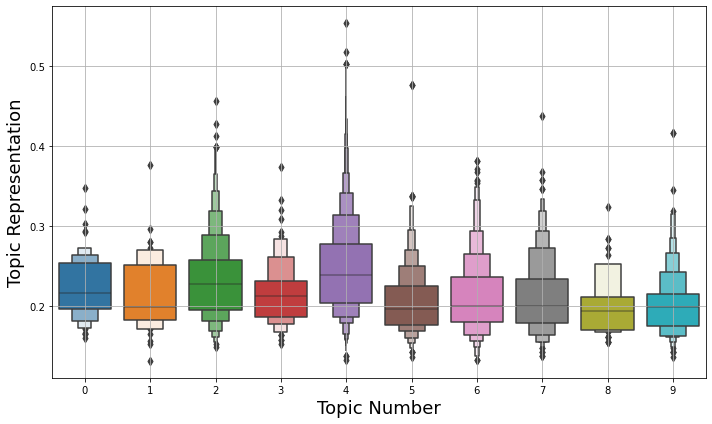

In [230]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.boxenplot(data=lda_df, y='Topic_Rep', x='Dominant_Topic')
plt.xlabel('Topic Number', fontsize=18)
plt.ylabel('Topic Representation', fontsize=18)
plt.tight_layout()
plt.grid()
fig.savefig('./figures/topic_vs_representation_lda.png')

In [231]:
dp.Report(dp.DataTable(lda_df[['Title', 'Subtitle', 'Dominant_Topic', 'Topic_Rep']])).upload("lda_df")

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/sejaldua/reports/BAmpGek/lda-df/) to view and share your report

### tSNE Dimension Reduction

In [232]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.20]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7067 samples in 0.003s...
[t-SNE] Computed neighbors for 7067 samples in 0.569s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7067
[t-SNE] Computed conditional probabilities for sample 2000 / 7067
[t-SNE] Computed conditional probabilities for sample 3000 / 7067
[t-SNE] Computed conditional probabilities for sample 4000 / 7067
[t-SNE] Computed conditional probabilities for sample 5000 / 7067
[t-SNE] Computed conditional probabilities for sample 6000 / 7067
[t-SNE] Computed conditional probabilities for sample 7000 / 7067
[t-SNE] Computed conditional probabilities for sample 7067 / 7067
[t-SNE] Mean sigma: 0.032191
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.320374
[t-SNE] KL divergence after 1000 iterations: 2.366474


In [233]:
import plotly.express as px 
import datapane as dp 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


lda_df['tsne_lda_0'] = list(tsne_lda[:,0])
lda_df['tsne_lda_1'] = list(tsne_lda[:,1])
lda_df['color'] = lda_df['Dominant_Topic'].astype(str)
lda_df['size'] = scaler.fit_transform(lda_df['Topic_Rep'].values.reshape(-1,1))

fig = px.scatter(lda_df, x="tsne_lda_0", y="tsne_lda_1",
                 color="color", size='size', size_max=20,
                custom_data=['Title', 'Subtitle', 'Dominant_Topic', 'Topic_Rep'])

fig.update_traces(
    hovertemplate="<br>".join([
        "Title: %{customdata[0]}",
        "Subtitle: %{customdata[1]}",
        "Topic Num: %{customdata[2]}",
        "Topic Rep: %{customdata[3]}"
    ])
)



report = dp.Report(dp.Plot(fig) ) #Create a report
report.upload(name='10 topic tSNE scatter plot')

fig

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/sejaldua/reports/j3LQY47/10-topic-tsne-scatter-plot/) to view and share your report

In [234]:
# Plot the Topic Clusters using Bokeh


from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper, ColorBar
from bokeh.palettes import plasma
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.palettes import d3
from bokeh.palettes import brewer, plasma
from bokeh.palettes import Viridis256, Category10
from bokeh.transform import factor_cmap

list_x = list(tsne_lda[:,0])
list_y = list(tsne_lda[:,1])


source = ColumnDataSource(data=dict(
    x=list_x, 
    y=list_y, 
    topic_num=list(lda_df['Dominant_Topic']),
    title=list(lda_df['Title']),
    subtitle=list(lda_df['Subtitle']),
    topic_rep = [x * 2 + 0.2 for x in list(lda_df['Topic_Rep'])]))
#     sizes=[(x * 100) // 10 + 2 for x in list(lda_df['Topic_Rep'])]))

hover = HoverTool(tooltips=[
    ("index", "$index"),
    ('title', '@title'),
    ('subtitle', '@subtitle'),
    ("topic", '@topic_num')
])


mapper = LinearColorMapper(palette='Spectral10', low=min(lda_df['Dominant_Topic'].unique()), high=max(lda_df['Dominant_Topic'].unique()))


p = figure(title="t-SNE Clustering of {} LDA Topics".format(lda_model.num_topics), 
           plot_width=900, plot_height=700, tools=[hover])
p.circle('x', 'y',
         alpha='topic_rep',
         fill_color={'field': 'topic_num', 'transform': mapper}, 
         line_color={'field': 'topic_num', 'transform': mapper}, 
         source=source)
color_bar = ColorBar(color_mapper=mapper, width=8,  location=(0,0))
p.add_layout(color_bar, 'right')
show(p)

## LDA Mallet Model

In [235]:
mallet_path = '~/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [236]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False)[:3])

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_preprocessed, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score: ', round(coherence_ldamallet, 2))

[(0,
  [('simple', 0.043170103092783504),
   ('part', 0.03994845360824742),
   ('tool', 0.0390893470790378),
   ('tip', 0.027061855670103094),
   ('api', 0.024269759450171822),
   ('company', 0.020403780068728523),
   ('twitter', 0.018900343642611683),
   ('trick', 0.01632302405498282),
   ('development', 0.0156786941580756),
   ('dataset', 0.01524914089347079)]),
 (1,
  [('make', 0.07799261351292636),
   ('life', 0.052791657614599176),
   ('year', 0.04931566369758853),
   ('developer', 0.030849446013469478),
   ('story', 0.022593960460569194),
   ('write', 0.02237671084075603),
   ('question', 0.01955246578318488),
   ('read', 0.019335216163371714),
   ('change', 0.01911796654355855),
   ('show', 0.017814468824679557)]),
 (2,
  [('python', 0.2417090539165819),
   ('text', 0.04292980671414039),
   ('nlp', 0.0358087487283825),
   ('panda', 0.029094608341810782),
   ('feature', 0.026653102746693795),
   ('tutorial', 0.025839267548321464),
   ('processing', 0.021363173957273652),
   ('bas

In [84]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Find most optimal number of topics

In [85]:
# NOTE: can take a long time to run...
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_preprocessed, start=4, limit=40, step=4)

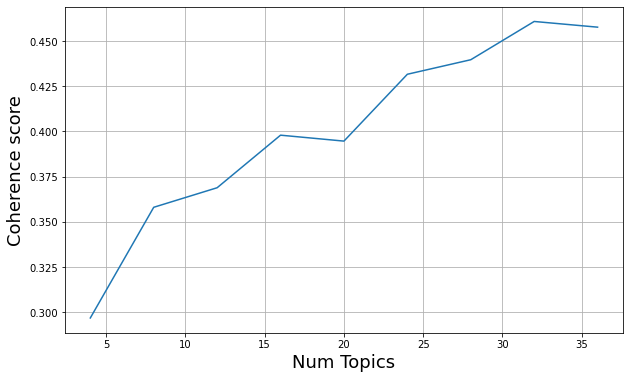

In [86]:
# Graph coherence values vs number of topics
limit=40; start=4; step=4;
x = range(start, limit, step)
fig = plt.figure(figsize=(10,6))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics", fontsize=18)
plt.ylabel("Coherence score", fontsize=18)
plt.grid()
fig.savefig('./figures/coherence_vs_numtopics.png')

In [87]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.2969
Num Topics = 8  has Coherence Value of 0.3581
Num Topics = 12  has Coherence Value of 0.3689
Num Topics = 16  has Coherence Value of 0.398
Num Topics = 20  has Coherence Value of 0.3947
Num Topics = 24  has Coherence Value of 0.4316
Num Topics = 28  has Coherence Value of 0.4397
Num Topics = 32  has Coherence Value of 0.4608
Num Topics = 36  has Coherence Value of 0.4577


In [89]:
# optimal_model = model_list[coherence_values.index(max(coherence_values))]
optimal_model = model_list[-2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(13,
  '0.532*"datum" + 0.170*"analysis" + 0.066*"visualization" + 0.049*"scrape" + '
  '0.040*"exploratory" + 0.026*"statistical" + 0.018*"identify" + '
  '0.013*"clean" + 0.013*"visualisation" + 0.012*"point"'),
 (16,
  '0.230*"work" + 0.092*"pandemic" + 0.071*"big" + 0.061*"tech" + 0.056*"home" '
  '+ 0.034*"lead" + 0.033*"back" + 0.032*"startup" + 0.028*"mistake" + '
  '0.024*"remote"'),
 (15,
  '0.149*"part" + 0.080*"love" + 0.054*"podcast" + 0.047*"test" + '
  '0.042*"series" + 0.033*"introduce" + 0.033*"team" + 0.033*"community" + '
  '0.033*"play" + 0.031*"grow"'),
 (24,
  '0.179*"react" + 0.154*"app" + 0.125*"web" + 0.120*"create" + '
  '0.089*"application" + 0.049*"deploy" + 0.037*"component" + '
  '0.032*"streamlit" + 0.031*"hook" + 0.028*"page"'),
 (3,
  '0.112*"make" + 0.062*"word" + 0.055*"lot" + 0.054*"popular" + '
  '0.051*"approach" + 0.050*"real" + 0.042*"high" + 0.038*"relationship" + '
  '0.035*"move" + 0.033*"sign"'),
 (2,
  '0.143*"text" + 0.117*"nlp" + 0.103*"cl

### pyLDAvis: Topic Distance Visualization and Relevant Terms

In [95]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [96]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
24    -0.000973 -0.144242  1       1        3.226297
29    -0.023248 -0.055781  2       1        3.223125
2      0.003152 -0.043561  3       1        3.220092
13     0.380780  0.016082  4       1        3.193020
10    -0.011901  0.003287  5       1        3.160783
28     0.418319  0.072458  6       1        3.158045
27     0.177105  0.050483  7       1        3.145178
23    -0.041463 -0.114750  8       1        3.134698
30    -0.038937 -0.065998  9       1        3.134085
18     0.058219 -0.171553  10      1        3.127854
19    -0.010616 -0.086453  11      1        3.124141
4     -0.025744 -0.052934  12      1        3.123385
20    -0.036653 -0.035581  13      1        3.121483
7     -0.029553  0.099358  14      1        3.117996
12    -0.037553 -0.011960  15      1        3.115769
11    -0.027627 -0.052947  16      1        3.111032
31    -0.045704  0.037802  17      1        3.109378
16    -0.061954  0.005367  18      1        3.108361
22    -0.082310  0.285826  19      1        3.107390
25    -0.044856  0.019000  20      1        3.106559
3     -0.070855  0.305353  21      1        3.104165
26    -0.057404 -0.021796  22      1        3.103965
6     -0.058789 -0.074803  23      1        3.103309
21    -0.037604 -0.002703  24      1        3.101429
14    -0.047614  0.002379  25      1        3.094912
8     -0.020023 -0.063164  26      1        3.093448
0     -0.042604 -0.022687  27      1        3.091884
15    -0.015300  0.013280  28      1        3.091547
17    -0.039996 -0.009612  29      1        3.091121
9     -0.032719  0.050662  30      1        3.087987
5     -0.040662 -0.074019  31      1        3.085937
1     -0.054910  0.143206  32      1        3.081625, topic_info=                Term         Freq        Total Category  logprob  loglift
8    datum            1312.000000  1312.000000  Default  30.0000  30.0000
17   learn            801.000000   801.000000   Default  29.0000  29.0000
100  machine          554.000000   554.000000   Default  28.0000  28.0000
13   make             667.000000   667.000000   Default  27.0000  27.0000
22   science          615.000000   615.000000   Default  26.0000  26.0000
..       ...                 ...          ...       ...      ...      ...
749  experiment       24.643399    34.154164    Topic32 -4.1109   3.1533 
698  practical_guide  18.482551    29.530671    Topic32 -4.3986   3.0111 
402  request          17.250380    29.356487    Topic32 -4.4675   2.9480 
461  show             35.732932    125.145670   Topic32 -3.7393   2.2263 
254  analytic         18.482551    43.291636    Topic32 -4.3986   2.6286 

[1081 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
61    10     0.037490  access 
61    13     0.337414  access 
61    16     0.637338  access 
497   17     0.204989  accord 
497   18     0.029284  accord 
...   ..          ...     ... 
854   27     0.027911  yous   
854   29     0.921052  yous   
845   11     1.009687  youtube
839   5      0.038985  zoom   
839   18     0.974637  zoom   

[1678 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 30, 3, 14, 11, 29, 28, 24, 31, 19, 20, 5, 21, 8, 13, 12, 32, 17, 23, 26, 4, 27, 7, 22, 15, 9, 1, 16, 18, 10, 6, 2])

### Finding the dominant topic in each sentence

In [98]:
def get_dominant_topics(ldamodel=lda_model, corpus=corpus, texts=texts):
    sent_topics_df = pd.DataFrame()

    # Get dominant topic in each document and the probability associated with it
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        dom_topic = row[0]
        topic_num, topic_rep = dom_topic
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(topic_rep,4)]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Rep']
    sent_topics_df['Dominant_Topic'] = sent_topics_df['Dominant_Topic'].astype(int)
    return(sent_topics_df)

df_with_mallet_topics = get_dominant_topics(ldamodel=optimal_model, corpus=corpus, texts=texts)
ldamallet_df = pd.concat([df, df_with_mallet_topics], axis=1)
ldamallet_df

date  \
0     2021-08-30 11:40:00+00:00   
1     2021-08-30 11:40:00+00:00   
2     2021-08-30 11:40:00+00:00   
3     2021-08-30 11:40:00+00:00   
4     2021-08-30 11:40:00+00:00   
...                         ...   
7062  2020-01-01 16:30:00+00:00   
7063  2020-01-01 16:30:00+00:00   
7064  2020-01-01 16:30:00+00:00   
7065  2020-01-01 16:30:00+00:00   
7066  2020-01-01 16:30:00+00:00   

                                                                              Title  \
0     Towards Better Data Visualizations and Graphics                                 
1     Making Sense of 33 Million Rows of Instacart Data: Exploratory Data Analysis…   
2     Data Science Learning Path with Python                                          
3     Jupyter Notebook can do that?                                                   
4     Reshaping Mitochondria to Reverse Obesity                                       
...                                         ...                                       
7062  How to Get the Unquantifiable Benefits of Cold Showers                          
7063  Screw Productivity Hacks: My Morning Routine Is Getting up Late                 
7064  The Latest Science on Chronic Pain Is Fascinating                               
7065  5 scientific myths you probably believe about the Universe                      
7066  How Jo March Became a Girlboss                                                  

                                                                                                           Subtitle  \
0     Design principles for creating data-based graphics and visuals                                                  
1     Instacart is one of the hottest Silicon Valley startups of the last decade and is now valued at whopping $39…   
2     I often receive messages from new members of Jakarta AI Research Discord Server, "where do I start to learn…    
3     Soup up your cells with a couple of key extensions                                                              
4     Changing the shape of mitochondria can reverse some of the molecular processes underlying obesity (in mice)     
...                                                                                                           ...     
7062  The surprising side effects that science can't measure and money can't buy                                      
7063  Anyone who brags about a 3:30 a.m. gym routine is sending a clear signal: Time is a thing to be optimized…      
7064  Experts can even predict who's likely to suffer or recover, based on brain structure and personality            
7065  How a little knowledge can bring about some huge misconceptions… and how to fix it.                             
7066  Every generation gets the 'Little Women' it deserves, and Greta Gerwig's film tells the story of a hungry…      

                      Author                Publication  Minutes  \
0     Prashant Mudgal         Towards Data Science       5         
1     Vijay Vankayalapati     Geek Culture               6         
2     Andreas Chandra         Data Folks Indonesia       3         
3     Jesse Markowitz         CodeX                      5         
4     Gunnar De Winter        In Fitness And In Health   4         
...                ...                              ... ..         
7062  May Pang                Better Humans              10        
7063  Jessica Valenti         GEN                        3         
7064  Robert Roy Britt        Elemental                  14        
7065  Ethan Siegel            Starts With A Bang!        8         
7066  Madeline Leung Coleman  GEN                        9         

                                                                                                                                            text  \
0     towards better data visualization graphic design principle creating databased graphic visuals                                                
1     making sense 

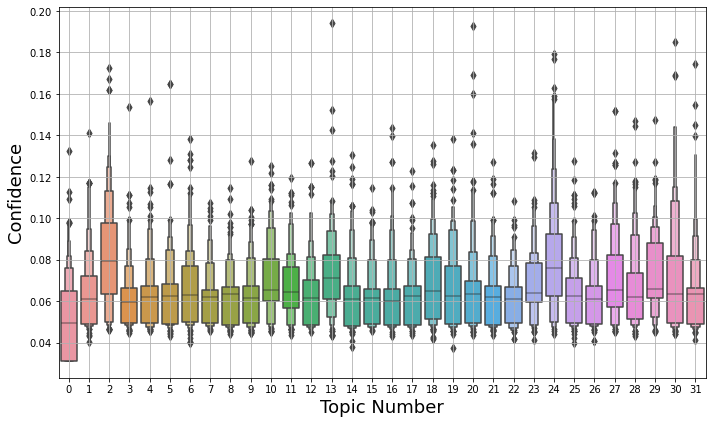

In [99]:
fig = plt.figure(figsize=(10,6))
sns.boxenplot(data=ldamallet_df, y='Topic_Rep', x='Dominant_Topic')
plt.xlabel('Topic Number', fontsize=18)
plt.ylabel('Topic Representation', fontsize=18)
plt.tight_layout()
plt.grid()
fig.savefig('./figures/topic_vs_representation_ldamallet.png')

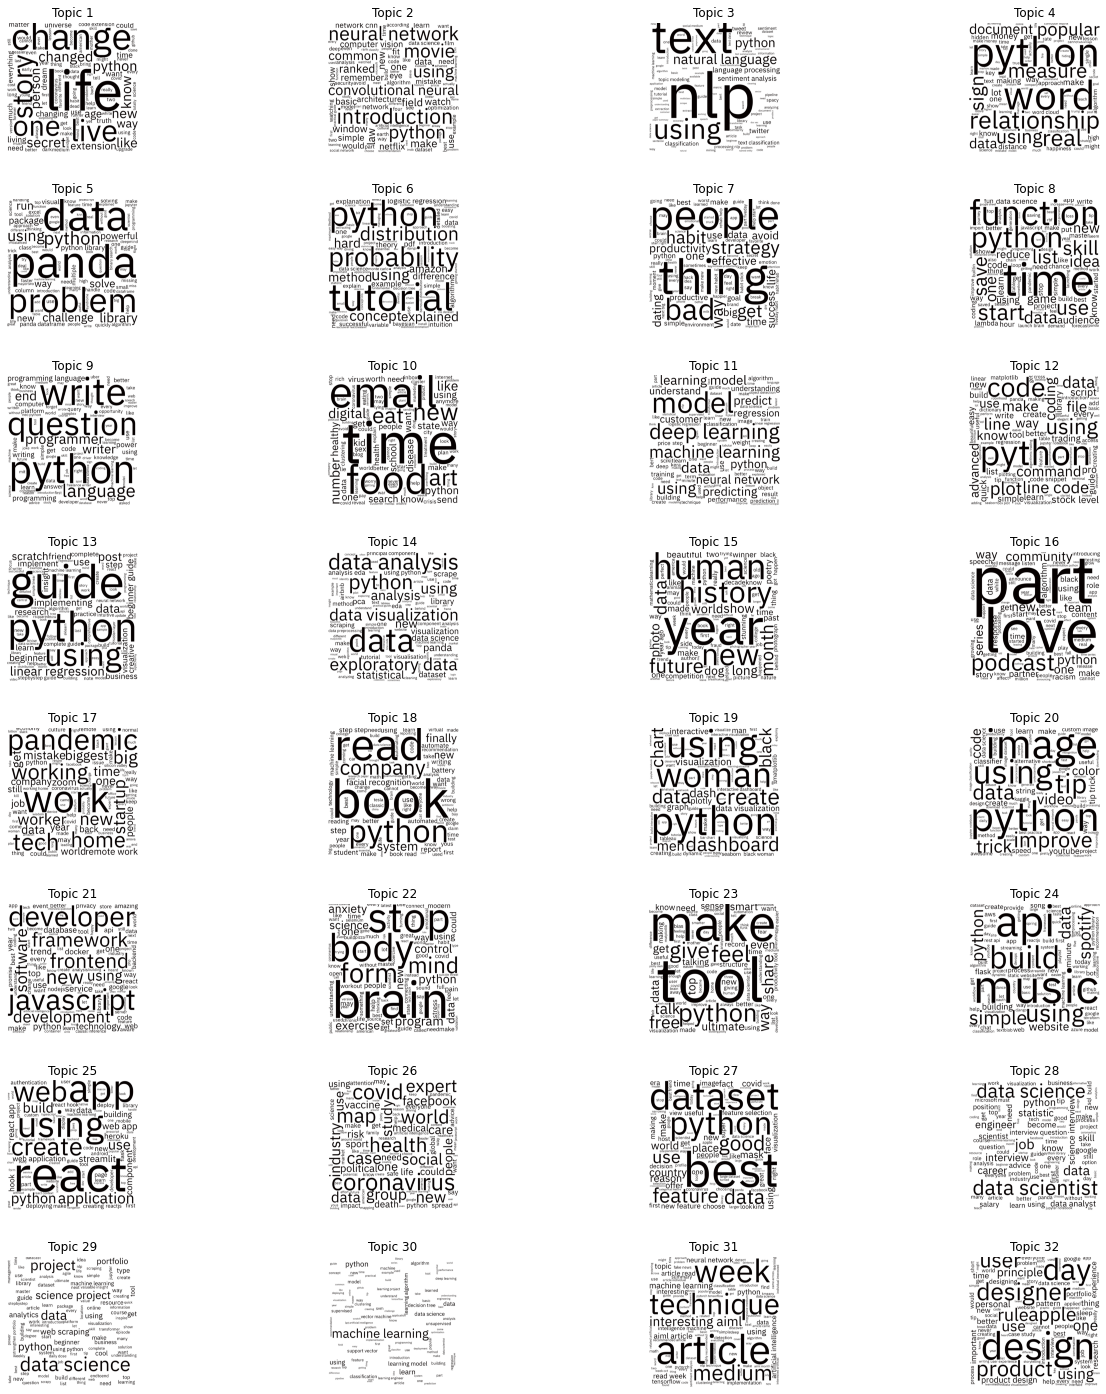

In [100]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

num_topics = optimal_model.num_topics
fig, ax = plt.subplots(num_topics // 4, int(num_topics / (num_topics // 4)), figsize=(20, 20))
for i in range(num_topics):
    text = ' '.join(ldamallet_df.loc[ldamallet_df['Dominant_Topic']==i, 'text'].values)    
    wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Regular.ttf', 
                      background_color="white", width=2000, height=2000, max_words=100, random_state=42, 
                      collocations=True, stopwords=stop_words, ).generate(text)
    # set the word color to black
    wordcloud.recolor(color_func = black_color_func)
    ax[i // 4, i % 4].imshow(wordcloud) 
    ax[i // 4, i % 4].set_title(f"Topic {i+1}")
    # No axis details
    ax[i // 4, i % 4].axis("off");
    
plt.tight_layout(pad=3);
fig.savefig('figures/topic_wordclouds.png')

### Find the most representative document for each topic

In [106]:
dp.Report(
    lda_df,
    fig).upload('test')

Uploading report and associated data - *please wait...*

Report successfully uploaded, click [here](https://datapane.com/u/sejaldua/reports/d7dXmn7/test/) to view and share your report

In [101]:
# Group top sentence under each topic
topic_df = pd.DataFrame()
sent_topics_outdf_grpd = ldamallet_df[['Dominant_Topic', 'Topic_Rep', 'text']].groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    topic_df = pd.concat([topic_df, grp.sort_values(['Topic_Proba'], ascending=[0]).head(1)], axis=0)

# Reset Index    
topic_df.reset_index(drop=True, inplace=True)
topic_df['Dominant_Topic'] = topic_df['Dominant_Topic'].astype(int)
topic_df.rename(columns={'Dominant_Topic': 'Topic_Num', 'text': 'Representative Doc'}, inplace=True)

# Get topic keywords
def get_keywords(topic_num):
    wp = optimal_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    return topic_keywords

topic_df['Keywords'] = topic_df['Topic_Num'].apply(lambda x: get_keywords(x))
topic_df

Topic_Num  Topic_Proba  \
0   0          0.1324        
1   1          0.1409        
2   2          0.1724        
3   3          0.1539        
4   4          0.1566        
5   5          0.1649        
6   6          0.1380        
7   7          0.1076        
8   8          0.1146        
9   9          0.1276        
10  10         0.1252        
11  11         0.1193        
12  12         0.1269        
13  13         0.1940        
14  14         0.1303        
15  15         0.1145        
16  16         0.1434        
17  17         0.1228        
18  18         0.1353        
19  19         0.1380        
20  20         0.1927        
21  21         0.1271        
22  22         0.1081        
23  23         0.1315        
24  24         0.1793        
25  25         0.1278        
26  26         0.1126        
27  27         0.1515        
28  28         0.1471        
29  29         0.1475        
30  30         0.1852        
31  31         0.1743        

                                                                                                                                     Representative Doc  \
0   tiny life upgrade cost living life quality not cost anything                                                                                          
1   netflixs watched original movie ranked worst best time rank netflixs watched movie according quality instead view                                     
2   task nlp twitter sentiment analysis twitter sentiment analysis natural language processing tutorial task fast                                         
3   create word document nodejs microsoft word popular word processor popular format making exchanging document                                           
4   data cleaning using panda library solve machine learning problem need panda library without panda library not                                         
5   bernoulli distribution probability tutorial python bernoulli distribution tutorial diving discrete probability distribution random variable           
6   developer environment hack increase productivity simple effective environment improvement make life developer efficient effective                     
7   interesting python builtin function operator put toolbox least one time spend considerable amount time trying write function                          
8   interviewing uber junior dev phone interview technical question recently spoke junior web developer tough time ubers phone interview thought          
9   insane even discussing sending kid school fall sophies choice continued house arrest potentially exposing kid virus                                   
10  regression machine learning regression model used predict continuous value predicting price house given feature                                       
11  pair trading line python code fetching similar stock pair trading                                                                                     
12  writer guide igniting work stepbystep practice prompt create creative sparkand help follow published                                                  
13  data preprocessing exploratory data analysis eda data science use different data preprocessing exploratory data analysis eda technique prepare data   
14  stunning photo show delicate beauty bird breathtaking winner prestigious bird photographer year competition                                           
15  watson text speech release new neural voice pleased announce watson text speech introduced five new neural voice four english                         
16  remote work killing hidden trilliondollar office economy airline starbucks massive part economy hinge whitecollar worker returning                    
17  classic mathematics book lifelong learner college student saw list essential math book blog promised read                                             
18  interactive scalable dashboard vaex dash learn build interactive

In [102]:
# Number of Documents for Each Topic
num_documents = pd.DataFrame(ldamallet_df['Dominant_Topic'].value_counts())   
num_documents.reset_index(inplace=True)
num_documents.columns = ['Dominant_Topic', 'Num_Documents']

# Percentage of Documents for Each Topic
num_documents['Perc_Documents'] = num_documents['Num_Documents'].apply(lambda x: round(x/num_documents['Num_Documents'].values.sum(), 4))

# Merge with other df containing keywords for each topic
topic_df = num_documents.merge(topic_df[['Topic_Num', 'Keywords']], 
                          left_on='Dominant_Topic', right_on='Topic_Num', how='left').drop(columns=['Dominant_Topic'])

topic_df

Num_Documents  Perc_Documents  Topic_Num  \
0   374            0.0529          0           
1   297            0.0420          24          
2   296            0.0419          2           
3   295            0.0417          29          
4   283            0.0400          16          
5   256            0.0362          31          
6   253            0.0358          14          
7   251            0.0355          27          
8   250            0.0354          18          
9   247            0.0350          8           
10  238            0.0337          9           
11  235            0.0333          25          
12  227            0.0321          20          
13  225            0.0318          17          
14  225            0.0318          15          
15  211            0.0299          11          
16  207            0.0293          21          
17  207            0.0293          13          
18  206            0.0291          4           
19  201            0.0284          12          
20  200            0.0283          6           
21  200            0.0283          10          
22  198            0.0280          28          
23  187            0.0265          30          
24  183            0.0259          19          
25  183            0.0259          1           
26  178            0.0252          3           
27  164            0.0232          26          
28  163            0.0231          5           
29  160            0.0226          7           
30  137            0.0194          23          
31  130            0.0184          22          

                                                                                                       Keywords  
0   life, change, story, live, secret, lose, bring, extension, age, person                                       
1   react, app, web, create, application, deploy, component, streamlit, hook, page                               
2   text, nlp, classification, processing, natural_language, twitter, analyze, review, sentiment_analysis, task  
3   learn, machine, learning, decision_tree, unsupervised, supervise, support_vector, essential, loss, testing   
4   work, pandemic, big, tech, home, lead, back, startup, mistake, remote                                        
5   design, day, user, product, experience, designer, apple, break, rule, personal                               
6   year, long, future, human, happen, world, month, history, beautiful, show                                    
7   data, scientist, science, job, interview, engineer, career, statistic, advice, analyst                       
8   create, visualization, woman, black, interactive, explore, man, dashboard, chart, graph                      
9   write, programming, language, question, end, power, answer, writer, programmer, platform                     
10  time, search, state, art, number, blog, digital, email, food, worth                                          
11  world, map, coronavirus, health, covid, social, case, industry, facebook, study                              
12  developer, javascript, top, development, trend, framework, technology, service, software, frontend           
13  step, read, book, company, system, automate, finally, report, facial_recognition, buy                        
14  part, love, podcast, test, series, introduce, team, community, play, grow                                    
15  code, python, line, easy, plot, add, file, level, advanced, perform                                          
16  stop, brain, form, set, great, master, call, mind, turn, program                                             
17  datum, analysis, visualization, scrape, exploratory, statistical, identify, clean, visualisation, point      
18  library, problem, panda, run, challenge, powerful, solve, visual, handle, class                              
19  guide, beginner, post, implement, research, business, scratch, complete, focus, linear_regression            
20  thing, people, bad, h